# Demand forecasting with BigQuery and TensorFlow

## BigQuery tutorial

In this notebook, we will develop a machine learning model to predict the demand for taxi cabs in New York.

To develop the model, we will need to get historical data of taxicab usage. This data exists in BigQuery. Let's start by looking at the schema.

In [1]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

In [2]:
%bq tables describe --name bigquery-public-data.new_york.tlc_yellow_trips_2015


### Analyzing taxicab demand
Let's pull the number of trips for each day in the 2015 dataset using Standard SQL.

In [4]:
%bq query
SELECT
  EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2015`
LIMIT 5

daynumber
199
74
120
148
171


#### Modular queries and Pandas dataframe
Let's use the total number of trips as our proxy for taxicab demand (other reasonable alternatives are total trip_distance or total fare_amount). It is possible to predict multiple variables using Tensorflow, but for simplicity, we will stick to just predicting the number of trips.

We will give our query a name 'taxiquery' and have it use an input variable '$YEAR'. We can then invoke the 'taxiquery' by giving it a YEAR. The to_dataframe() converts the BigQuery result into a Pandas dataframe.

In [5]:
%bq query -n taxiquery
WITH trips AS (
  SELECT EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber 
  FROM `bigquery-public-data.new_york.tlc_yellow_trips_*`
  where _TABLE_SUFFIX = @YEAR
)
SELECT daynumber, COUNT(1) AS numtrips FROM trips
GROUP BY daynumber ORDER BY daynumber

In [8]:
type(taxiquery)

google.datalab.bigquery._query.Query

In [11]:
query_parameters = [
  {
    'name': 'YEAR',
    'parameterType': {'type': 'STRING'},
    'parameterValue': {'value': 2015}
  }
]
trips = taxiquery.execute(query_params=query_parameters).result().to_dataframe()
trips[:5]

,daynumber,numtrips
0,1,382014
1,2,345296
2,3,406769
3,4,328848
4,5,363454


#### Benchmark
Often, a reasonable estimate of something is its historical average. We can therefore benchmark our machine learning model against the historical average.

In [12]:
avg = np.mean(trips['numtrips'])
print 'Just using average={0} has RMSE of {1}'.format(avg, np.sqrt(np.mean((trips['numtrips'] - avg)**2)))

Just using average=400309.558904 has RMSE of 51613.6516905



The mean here is about 400,000 and the root-mean-square-error (RMSE) in this case is about 52,000. In other words, if we were to estimate that there are 400,000 taxi trips on any given day, that estimate is will be off on average by about 52,000 in either direction.

Let's see if we can do better than this -- our goal is to make predictions of taxicab demand whose RMSE is lower than 52,000.

What kinds of things affect people's use of taxicabs?

### Weather data
We suspect that weather influences how often people use a taxi. Perhaps someone who'd normally walk to work would take a taxi if it is very cold or rainy.

One of the advantages of using a global data warehouse like BigQuery is that you get to mash up unrelated datasets quite easily.

In [14]:
%bq query
SELECT * FROM `bigquery-public-data.noaa_gsod.stations`
WHERE state = 'NY' AND wban != '99999' AND name like '%LA GUARDIA%'

usaf,wban,name,country,state,call,lat,lon,elev,begin,end
725030,14732,LA GUARDIA AIRPORT,US,NY,KLGA,40.779,-73.88,+0003.4,19730101,20180212


#### Variables
Let's pull out the minimum and maximum daily temperature (in Fahrenheit) as well as the amount of rain (in inches) for La Guardia airport.

In [16]:
%bq query -n weatherquery
SELECT EXTRACT (DAYOFYEAR FROM CAST(CONCAT(@YEAR, '-', mo, '-',da) AS TIMESTAMP)) AS daynumber,
  MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(@YEAR, '-',mo,'-',da) AS TIMESTAMP))) dayofweek,
  MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
FROM `bigquery-public-data.noaa_gsod.gsod*`
WHERE stn='725030' AND _TABLE_SUFFIX = @YEAR
GROUP BY 1 ORDER BY daynumber DESC

In [18]:
query_parameters = [
  {
    'name': 'YEAR',
    'parameterType': {'type': 'STRING'},
    'parameterValue': {'value': 2015}
  }
]
weather = weatherquery.execute(query_params=query_parameters).result().to_dataframe()
weather[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain
0,365,5,46.0,48.2,0.17
1,364,4,34.0,48.0,0.13
2,363,3,33.8,46.9,0.37
3,362,2,39.0,62.1,0.02
4,361,1,46.0,62.6,0.14


#### Merge datasets
Let's use Pandas to merge (combine) the taxi cab and weather datasets day-by-day.

In [19]:
data = pd.merge(weather, trips, on='daynumber')
data[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,365,5,46.0,48.2,0.17,339939
1,364,4,34.0,48.0,0.13,319649
2,363,3,33.8,46.9,0.37,311730
3,362,2,39.0,62.1,0.02,301398
4,361,1,46.0,62.6,0.14,268841


### Exploratory analysis
Is there a relationship between maximum temperature and the number of trips?

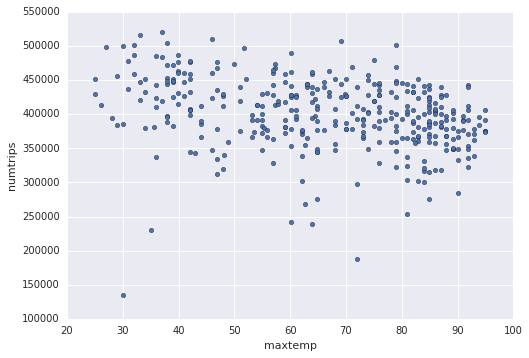

In [20]:
j = data.plot(kind='scatter', x='maxtemp', y='numtrips')


Is there a relationship between the day of the week and the number of trips?

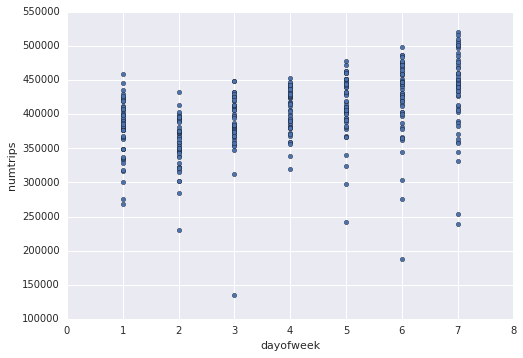

In [21]:
j = data.plot(kind='scatter', x='dayofweek', y='numtrips')


Perhaps if we took out the confounding effect of the day of the week, maximum temperature will start to have an effect. Let's see if that's the case:

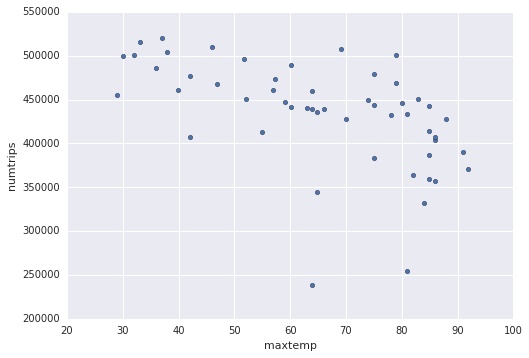

In [22]:
j = data[data['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

### Adding 2014 and 2016 data


In [23]:
data2 = data # 2015 data
for year in [2014, 2016]:
    query_parameters = [
      {
        'name': 'YEAR',
        'parameterType': {'type': 'STRING'},
        'parameterValue': {'value': year}
      }
    ]
    weather = weatherquery.execute(query_params=query_parameters).result().to_dataframe()
    trips = taxiquery.execute(query_params=query_parameters).result().to_dataframe()
    data_for_year = pd.merge(weather, trips, on='daynumber')
    data2 = pd.concat([data2, data_for_year])
data2.describe()

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,183.166971,4.005474,48.195073,66.151825,0.117272,403642.694343
std,105.510927,2.000449,18.031228,18.484065,0.320836,63767.524397
min,1.000000,1.000000,1.000000,21.000000,0.000000,78133.000000
25%,92.000000,2.000000,35.100000,51.950000,0.000000,363809.000000
50%,183.000000,4.000000,48.900000,68.000000,0.000000,402184.500000
75%,274.250000,6.000000,64.400000,82.900000,0.050000,447099.000000
max,366.000000,7.000000,82.000000,99.000000,4.880000,574530.000000


## Tensorflow tutorial